# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise` 中，我们可以发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。同样地，通过深度学习框架的高级API也能更方便地实现分类模型。让我们继续使用Fashion-MNIST数据集，并保持批量大小为256，就像在 :numref:`sec_softmax_scratch` 中一样。


In [1]:
from mxnet import gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax` 所述，[**softmax 回归的输出层是一个全连接层**]。因此，为了实现我们的模型，我们只需在 `Sequential` 中添加一个带有10个输出的全连接层。同样，在这里，`Sequential` 并不是必要的，但我们可能会形成这种习惯。因为在实现深度模型时，`Sequential`将无处不在。我们仍然以均值0和标准差0.01随机初始化权重。


In [3]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch` 的例子中，我们计算了模型的输出，然后将此输出送入交叉熵损失。从数学上讲，这是一件完全合理的事情。然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数 $\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，其中$\hat y_j$是预测的概率分布。$o_j$是未归一化的预测$\mathbf{o}$的第$j$个元素。如果$o_k$中的一些数值非常大，那么 $\exp(o_k)$ 可能大于数据类型容许的最大数字（即 *上溢*（overflow））。这将使分母或分子变为`inf`（无穷大），我们最后遇到的是0、`inf` 或 `nan`（不是数字）的 $\hat y_j$。在这些情况下，我们不能得到一个明确定义的交叉熵的返回值。

解决这个问题的一个技巧是，在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。你可以证明每个 $o_k$ 按常数进行的移动不会改变softmax的返回值。在减法和归一化步骤之后，可能有些 $o_j$ 具有较大的负值。由于精度受限， $\exp(o_j)$ 将有接近零的值，即 *下溢*（underflow）。这些值可能会四舍五入为零，使 $\hat y_j$ 为零，并且使得 $\log(\hat y_j)$ 的值为 `-inf`。反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。如下面的等式所示，我们避免计算$\exp(o_j)$，而可以直接使用$o_j$。因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j)}{\sum_k \exp(o_k)}\right) \\
& = \log{(\exp(o_j))}-\log{\left( \sum_k \exp(o_k) \right)} \\
& = o_j -\log{\left( \sum_k \exp(o_k) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，而是[**在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数**]，这是一件聪明的事情 ["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)。


In [4]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [5]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch` 中(~~之前~~)(**定义的训练函数来训练模型**)。


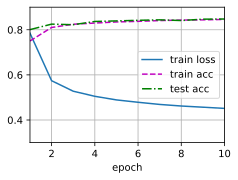

In [6]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法收敛到一个相当高的精度，而且这次的代码行比以前少了。

## 小结

* 使用高级 API，我们可以更简洁地实现 softmax 回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试准确率会在一段时间后降低？我们怎么解决这个问题？


[Discussions](https://discuss.d2l.ai/t/1794)
